In [1]:
import random
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import WhitespaceTokenizer
from nltk import sent_tokenize
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

Length of text input - 250 words

EDA and preprocessing ||
removed contractions, stop words, certain punctuation, dropped rows w/ na values ||
dataset visualized and EDA carried out ||
data augmentation NOT applied ||

##DETAILS ABOUT MODEL:

layers - 
input -> Embedding -> Encoder (LSTM) -> Decoder (LSTM) -> Dense layer over vocabulary ||

hidden dim size - 128 (128 units of 1 LSTM layer) ||

Embedding dim size - 30 ||

training parameters: batch size 64, epochs 20, did not stop early

In [2]:
dataset = pd.read_csv('mtsamples.csv')
dataset.drop("Unnamed: 0", axis = 1, inplace=True)
dataset.drop("keywords", axis = 1, inplace=True)

In [3]:
dataset.drop_duplicates()

,description,medical_specialty,sample_name,transcription
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...
...,...,...,...,...
4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e..."
4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH..."
4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema..."
4997,Mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"CHIEF COMPLAINT: , This 5-year-old male presen..."


In [4]:
dataset.shape

(4999, 4)

In [5]:
dataset.head()

,description,medical_specialty,sample_name,transcription
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...


In [6]:
#if package not found - run the next line of code
#nltk.download('stopwords')
#from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [7]:
dataset.dropna(axis = 0, inplace = True)

In [8]:
def remove_stopwords(text):
    if isinstance(text, str):
        new_text = []
        text = text.split()
        for word in text:
            if word not in stop_words:
                new_text.append(word)
        text = " ".join(new_text)
        return text

In [9]:
#from a kaggle notebook - will add reference 
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [10]:
def lowercase(object):
    if isinstance(object, str):
        object = str.lower(object)
    return object

def contractions(object):
    if isinstance(object, str):
        if object in contraction_mapping:
            temp_word = contraction_mapping[object]
            object = temp_word
    return object

def remove_punctuation(object):
    #leave ":" and "." - section and full stop, respectively. Info about sequences
    #remove "," ; "/" ; " "
    if isinstance(object, str): 
        expression = r"[!\#\$'\*\;%']"
        empty_str = ""
        result = re.sub(expression, empty_str, object, 0, re.MULTILINE)
        return result
    else:
        return object

"""def POS_tagger(object):
    if isinstance(object, str):
        #Map POS tag to first character lemmatize() accepts
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    else:
        return object"""
#flag 1,2,3 - 1 - lowercase, 2 - stopwords, 3 - contraction, 4 - punctuation,
#5 - lemmatizer
def apply_df(df, label, flag):
    if flag == 1:
        df.loc[:, label] = df[label].apply(lambda x : lowercase(x))
    elif flag == 2:
        df.loc[:, label] = df[label].apply(lambda x : remove_stopwords(x))
    elif flag == 3:
        df.loc[:, label] = df[label].apply(lambda x : contractions(x))
    elif flag == 4:
        df.loc[:, label] = df[label].apply(lambda x : remove_punctuation(x))
    return df
dataset = apply_df(dataset, 'transcription', 1)
dataset = apply_df(dataset, 'description', 1)
dataset.head()

,description,medical_specialty,sample_name,transcription
0,a 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"subjective:, this 23-year-old white female pr..."
1,consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"past medical history:, he has difficulty climb..."
2,consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"history of present illness: , i have seen abc ..."
3,2-d m-mode. doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-d m-mode: , ,1. left atrial enlargement wit..."
4,2-d echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. the left ventricular cavity size and wall ...


In [11]:
dataset = apply_df(dataset, 'transcription', 2)
dataset = apply_df(dataset, 'description', 2)
dataset = apply_df(dataset, 'transcription', 3)
dataset = apply_df(dataset, 'description', 3)
dataset = apply_df(dataset, 'transcription', 4)
dataset = apply_df(dataset, 'description', 4)

Converted to lowercase, removed stop words, contractions and certain punctuations.

In [97]:
#refactor
medical_specialties_list = []
trans_word_count_list = []
summary_word_count_list = []
for word in dataset['medical_specialty'].unique():
    medical_specialties_list.append(word)
    dataset_filtered = dataset[(dataset['medical_specialty'] == word)]
    trans_word_count = dataset_filtered['transcription'].str.split().str.len().sum()
    summary_word_count = dataset_filtered['description'].str.split().str.len().sum()
    trans_word_count_list.append(trans_word_count)
    summary_word_count_list.append(summary_word_count)
    
words_df = pd.DataFrame({'specialty': medical_specialties_list, 'text_word_count': trans_word_count_list, 'summary_word_count': summary_word_count_list})
words_df['text_word_count'] = words_df['text_word_count'].astype('int')
words_df['summary_word_count'] = words_df['summary_word_count'].astype('int')
words_df = words_df.sort_values('text_word_count', ascending=False)
words_df = words_df.sort_values('summary_word_count', ascending=False)
words_df.reset_index(drop=True, inplace = True)

In [68]:
words_df.head()

,specialty,text_word_count,summary_word_count
0,Surgery,311281,15697
1,Consult - History and Phy.,174469,6381
2,Cardiovascular / Pulmonary,100753,5648
3,Orthopedic,118102,5559
4,General Medicine,74040,3091


In [69]:
#all the different medical_specialty values:
dataset['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

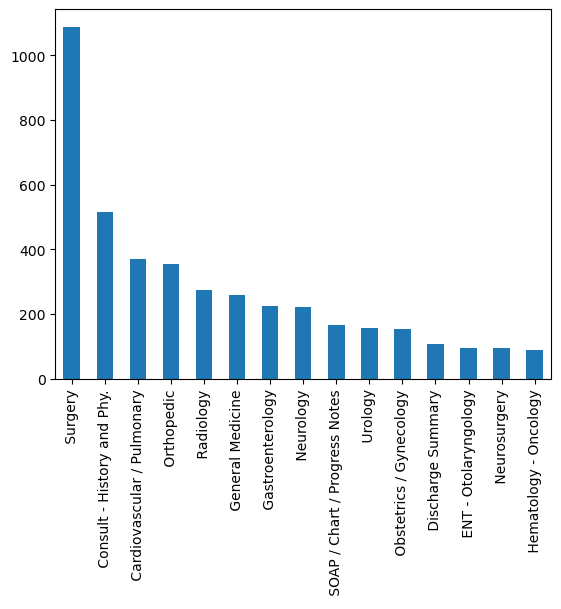

In [70]:
med_counts = dataset['medical_specialty'].value_counts()
ax = med_counts[:15].plot.bar(y = "Freq")
#frequency distribution of number of records - first 15

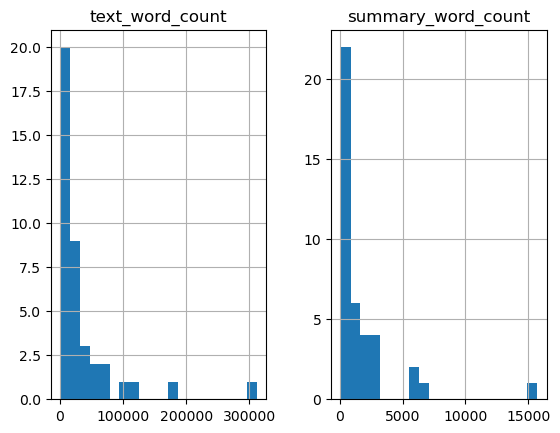

In [71]:
import matplotlib.pyplot as plt
words_df.hist(bins = 20)
plt.show()
#as expected, most text and summary counts are in the lowest 3 bins possible
#look at the difference in length between texts and summaries!

In [72]:
print(words_df['text_word_count'].describe(percentiles = [0.25, 0.5, 0.75, 0.90]))
print("\n")
print(words_df['summary_word_count'].describe(percentiles = [0.25, 0.5, 0.75, 0.90]))

count        40.000000
mean      34751.825000
std       57400.031418
min        1316.000000
25%        6276.500000
50%       15805.500000
75%       35214.000000
90%       76711.300000
max      311281.000000
Name: text_word_count, dtype: float64


count       40.000000
mean      1637.175000
std       2773.650634
min         66.000000
25%        190.750000
50%        669.000000
75%       1872.500000
90%       3337.800000
max      15697.000000
Name: summary_word_count, dtype: float64


In [12]:
train_dataset = dataset.drop('sample_name', axis = 1)
train_dataset = train_dataset.drop('medical_specialty', axis = 1)

In [13]:
train_dataset.head()

,description,transcription
0,23-year-old white female presents complaint al...,"subjective:, 23-year-old white female presents..."
1,consult laparoscopic gastric bypass.,"past medical history:, difficulty climbing sta..."
2,consult laparoscopic gastric bypass.,"history present illness: , seen abc today. ple..."
3,2-d m-mode. doppler.,"2-d m-mode: , ,1. left atrial enlargement left..."
4,2-d echocardiogram,1. left ventricular cavity size wall thickness...


In [14]:
print(train_dataset['description'].describe())
print("\n")
print(train_dataset['transcription'].describe())

count                                                  4966
unique                                                 2336
top       example/template routine normal male physical ...
freq                                                     12
Name: description, dtype: object


count                                                  4966
unique                                                 2357
top       preoperative diagnosis: , low back pain.,posto...
freq                                                      5
Name: transcription, dtype: object


In [76]:
#if albumntations not installed, run this line of code!
#pip install -U albumentations

In [77]:
from albumentations.core.transforms_interface import DualTransform, BasicTransform
class NLPTransform(BasicTransform):
    """ Transform for nlp task."""
    LANGS = {
        'en': 'english',
        'it': 'italian', 
        'fr': 'french', 
        'es': 'spanish',
        'tr': 'turkish', 
        'ru': 'russian',
        'pt': 'portuguese'
    }

    @property
    def targets(self):
        return {"data": self.apply}
    
    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation
        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value
        return params

    def get_sentences(self, text, lang='en'):
        return sent_tokenize(text, self.LANGS.get(lang, 'english'))

In [78]:
#refactor
#trying basic data augmentation: 
class ShuffleSentencesTransform(NLPTransform):
    """ Do shuffle by sentence """
    def __init__(self, always_apply=False, p=0.5):
        super(ShuffleSentencesTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        sentences = self.get_sentences(text, lang)
        random.shuffle(sentences)
        return ' '.join(sentences), lang
    
#referenced from - https://www.kaggle.com/code/shonenkov/nlp-albumentations/notebook

In [79]:
#if punkt missing, uncomment and run this!
#nltk.download('punkt')

In [11]:
transform = ShuffleSentencesTransform(p=1.0)
first_transformed_list = []

for iter in train_dataset['transcription']:
    text = iter
    lang = 'en'
    temp_text = transform(data=(text, lang))['data'][0]
    first_transformed_list.append(temp_text)

NameError: name 'ShuffleSentencesTransform' is not defined

In [81]:
len(first_transformed_list)

4966

In [82]:
first_summ_transformed_list = []

for iter in train_dataset['description']:
    first_summ_transformed_list.append(iter)

In [83]:
extended_dataset_1 = pd.DataFrame()
extended_dataset_1['transcription'] = first_transformed_list
extended_dataset_1['description'] = first_summ_transformed_list

In [84]:
extended_dataset_1.head()

,transcription,description
0,"past, tried claritin, zyrtec. used allergies l...",23-year-old white female presents complaint al...
1,"vital signs stable. denies cellulitis, pseudot...",consult laparoscopic gastric bypass.
2,gets tired quickly. drinks alcohol ten twelve ...,consult laparoscopic gastric bypass.
3,"normal size right left ventricle.,3. trace aor...",2-d m-mode. doppler.
4,aortic valve appears calcified mild aortic val...,2-d echocardiogram


In [85]:
extended_dataset_1['description']

0       23-year-old white female presents complaint al...
1                    consult laparoscopic gastric bypass.
2                    consult laparoscopic gastric bypass.
3                                    2-d m-mode. doppler.
4                                      2-d echocardiogram
                              ...                        
4961    patient severe sinusitis two three months ago ...
4962    14-month-old baby boy caucasian came presumpti...
4963    female complete physical follow asthma allergi...
4964                     mother states wheezing coughing.
4965    acute allergic reaction, etiology uncertain, h...
Name: description, Length: 4966, dtype: object

In [86]:
train_dataset['description']

0       23-year-old white female presents complaint al...
1                    consult laparoscopic gastric bypass.
2                    consult laparoscopic gastric bypass.
3                                    2-d m-mode. doppler.
4                                      2-d echocardiogram
                              ...                        
4994    patient severe sinusitis two three months ago ...
4995    14-month-old baby boy caucasian came presumpti...
4996    female complete physical follow asthma allergi...
4997                     mother states wheezing coughing.
4998    acute allergic reaction, etiology uncertain, h...
Name: description, Length: 4966, dtype: object

In [87]:
extended_dataset_10k = pd.concat([extended_dataset_1, train_dataset], keys = 'description', ignore_index = True)

In [88]:
extended_dataset_10k.head()

,transcription,description
0,"past, tried claritin, zyrtec. used allergies l...",23-year-old white female presents complaint al...
1,"vital signs stable. denies cellulitis, pseudot...",consult laparoscopic gastric bypass.
2,gets tired quickly. drinks alcohol ten twelve ...,consult laparoscopic gastric bypass.
3,"normal size right left ventricle.,3. trace aor...",2-d m-mode. doppler.
4,aortic valve appears calcified mild aortic val...,2-d echocardiogram


In [89]:
len(extended_dataset_10k)

9932

In [90]:
extended_dataset_10k.columns

Index(['transcription', 'description'], dtype='object')

In [91]:
extended_dataset_10k['description']

0       23-year-old white female presents complaint al...
1                    consult laparoscopic gastric bypass.
2                    consult laparoscopic gastric bypass.
3                                    2-d m-mode. doppler.
4                                      2-d echocardiogram
                              ...                        
9927    patient severe sinusitis two three months ago ...
9928    14-month-old baby boy caucasian came presumpti...
9929    female complete physical follow asthma allergi...
9930                     mother states wheezing coughing.
9931    acute allergic reaction, etiology uncertain, h...
Name: description, Length: 9932, dtype: object

In [92]:
extended_dataset_10k['transcription']

0       past, tried claritin, zyrtec. used allergies l...
1       vital signs stable. denies cellulitis, pseudot...
2       gets tired quickly. drinks alcohol ten twelve ...
3       normal size right left ventricle.,3. trace aor...
4       aortic valve appears calcified mild aortic val...
                              ...                        
9927    history:, pleasure meeting evaluating patient ...
9928    admitting diagnosis: , kawasaki disease.,disch...
9929    subjective: , 42-year-old white female comes t...
9930    chief complaint: , 5-year-old male presents ch...
9931    history: , 34-year-old male presents today sel...
Name: transcription, Length: 9932, dtype: object

In [93]:
second_transformed_list = []

for iter in extended_dataset_10k['transcription']:
    text = iter
    lang = 'en'
    temp_text = transform(data=(text, lang))['data'][0]
    second_transformed_list.append(temp_text)

In [94]:
len(second_transformed_list)

9932

In [95]:
second_summ_transformed_list = []

for iter in extended_dataset_10k['description']:
    second_summ_transformed_list.append(iter)

In [96]:
extended_dataset_2 = pd.DataFrame()
extended_dataset_2['transcription'] = second_transformed_list
extended_dataset_2['description'] = second_summ_transformed_list

In [97]:
extended_dataset_2

,transcription,description
0,appear working well. clear drainage seen. past...,23-year-old white female presents complaint al...
1,"muscle joint pains including knee pain, back p...",consult laparoscopic gastric bypass.
2,"eating, eats bad food. sleep apnea snoring. de...",consult laparoscopic gastric bypass.
3,"normal morphology aortic valve, mitral valve, ...",2-d m-mode. doppler.
4,tricuspid valve appears normal trace tricuspid...,2-d echocardiogram
...,...,...
9927,signs acute sinusitis. rarely drinks alcohol-c...,patient severe sinusitis two three months ago ...
9928,conjunctivitis redness mucous membranes. echoc...,14-month-old baby boy caucasian came presumpti...
9929,impatient around time. pap smear taken. premen...,female complete physical follow asthma allergi...
9930,"pupils equal, round, reactive light. masses. c...",mother states wheezing coughing.


In [98]:
extended_dataset_final = pd.concat([extended_dataset_10k, extended_dataset_2], keys = 'description', ignore_index = True)

In [99]:
extended_dataset_final

,transcription,description
0,"past, tried claritin, zyrtec. used allergies l...",23-year-old white female presents complaint al...
1,"vital signs stable. denies cellulitis, pseudot...",consult laparoscopic gastric bypass.
2,gets tired quickly. drinks alcohol ten twelve ...,consult laparoscopic gastric bypass.
3,"normal size right left ventricle.,3. trace aor...",2-d m-mode. doppler.
4,aortic valve appears calcified mild aortic val...,2-d echocardiogram
...,...,...
19859,signs acute sinusitis. rarely drinks alcohol-c...,patient severe sinusitis two three months ago ...
19860,conjunctivitis redness mucous membranes. echoc...,14-month-old baby boy caucasian came presumpti...
19861,impatient around time. pap smear taken. premen...,female complete physical follow asthma allergi...
19862,"pupils equal, round, reactive light. masses. c...",mother states wheezing coughing.


In [100]:
extended_dataset_final['description'][:10]

0    23-year-old white female presents complaint al...
1                 consult laparoscopic gastric bypass.
2                 consult laparoscopic gastric bypass.
3                                 2-d m-mode. doppler.
4                                   2-d echocardiogram
5    morbid obesity. laparoscopic antecolic antegas...
6    liposuction supraumbilical abdomen, revision r...
7                                   2-d echocardiogram
8    suction-assisted lipectomy - lipodystrophy abd...
9                               echocardiogram doppler
Name: description, dtype: object

In [101]:
#dataset = extended_dataset_final

In [102]:
## No data augmentation

In [15]:
dataset = train_dataset

In [16]:
dataset.tail()

,description,transcription
4994,patient severe sinusitis two three months ago ...,"history:, pleasure meeting evaluating patient ..."
4995,14-month-old baby boy caucasian came presumpti...,"admitting diagnosis: , kawasaki disease.,disch..."
4996,female complete physical follow asthma allergi...,"subjective: , 42-year-old white female comes t..."
4997,mother states wheezing coughing.,"chief complaint: , 5-year-old male presents ch..."
4998,"acute allergic reaction, etiology uncertain, h...","history: , 34-year-old male presents today sel..."


In [17]:
dataset.describe()

,description,transcription
count,4966,4966
unique,2336,2357
top,example/template routine normal male physical ...,"preoperative diagnosis: , low back pain.,posto..."
freq,12,5


In [18]:
filepath = ("mt_samples_preproc.csv")
dataset.to_csv(filepath)

In [2]:
filepath = ("mt_samples_preproc.csv")
dataset = pd.read_csv(filepath)

## Splitting train and test set

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(np.array(dataset['transcription']), np.array(dataset['description']), test_size = 0.05, random_state = 0, shuffle = False)

In [4]:
print("x_train shape : ", x_train.shape)
print("y_train shape : ", y_train.shape)
print("x_val shape : ", x_val.shape)
print("y_val shape : ", y_val.shape)

x_train shape :  (4717,)
y_train shape :  (4717,)
x_val shape :  (249,)
y_val shape :  (249,)


## NLP

In [5]:
#<BOS> - begin of sequence; <EOS> - end of sequence.
#refactor this!!
def sequence_tagger(input_sequence):
    bos = "<BOS> "
    eos = " <EOS>"
    tagged_sequence = []
    for text in input_sequence:
        if isinstance(text, str):
            tagged_sentence = bos + text + eos
            tagged_sequence.append(tagged_sentence)
    return tagged_sequence

tagged_seq_x_train = sequence_tagger(x_train)

In [6]:
print(len(tagged_seq_x_train))
print(tagged_seq_x_train[1])

4717
<BOS> past medical history:, difficulty climbing stairs, difficulty airline seats, tying shoes, used public seating, lifting objects floor. exercises three times week home cardio. difficulty walking two blocks five flights stairs. difficulty snoring. muscle joint pains including knee pain, back pain, foot ankle pain, swelling. gastroesophageal reflux disease.,past surgical history:, includes reconstructive surgery right hand 13 years ago. ,social history:, currently single. ten drinks year. smoked significantly several months ago. smokes less three cigarettes day.,family history:, heart disease grandfathers, grandmother stroke, grandmother diabetes. denies obesity hypertension family members.,current medications:, none.,allergies:, allergic penicillin.,miscellaneous/eating history:, going support groups seven months lynn holmberg greenwich eastchester, new york feels appropriate program. poor experience greenwich program. eating history, emotional eater. like sweets. likes big por

In [7]:
tagged_seq_x_val = sequence_tagger(x_val)
tagged_seq_y_train = sequence_tagger(y_train)
tagged_seq_y_val = sequence_tagger(y_val)

## Preparing a tokenizer and calculating no. of rare / common words

In [8]:
temp_list = tagged_seq_x_train

In [113]:
#temp_list[1]

In [9]:
from keras.preprocessing.text import Tokenizer

2023-08-21 19:37:44.189095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 19:37:44.857194: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-21 19:37:45.773282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/rkv/miniconda3/envs/tf/lib/
2023-08-21 19:37:45.776907: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.s

In [10]:
x_train_list = list(filter(None, temp_list))

In [116]:
#x_train_list[1]

In [11]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(x_train_list)

In [12]:
temp_list = list(tagged_seq_y_train)
#print(temp_list[1])
y_train_list = list(filter(None, temp_list))

In [13]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(y_train_list) #this object's internal vocab - these words

In [14]:
#refactor later
threshold = 16

total_words_desc = 0
total_words_summ = 0 
total_freq_desc = 0
total_freq_summ = 0 
rare_word_desc_count = 0
rare_word_summ_count = 0
rare_word_desc_freq = 0 
rare_word_summ_freq = 0
#less than say, 4 in the original text - now dataset is 4x size, so 16
#from internal vocabulary
for key, value in x_tokenizer.word_counts.items():
    #returns a word and it's frequency
    total_words_desc = total_words_desc + 1
    total_freq_desc = total_freq_desc + value
    if value < threshold :
        rare_word_desc_count = rare_word_desc_count + 1
        rare_word_desc_freq = rare_word_desc_freq + value
print("Transcription : ")
print("Rare words consist of", (rare_word_desc_count / total_words_desc) * 100, "% of the vocabulary")
#what does this following thing mean? :
print("Frequency of rare words relative to most frequent words(%):", (rare_word_desc_freq/total_freq_desc) * 100)

for key, value in y_tokenizer.word_counts.items():
    #returns a word and it's frequency
    total_words_summ = total_words_summ + 1
    total_freq_summ = total_freq_summ + value
    if value < threshold :
        rare_word_summ_count = rare_word_summ_count + 1
        rare_word_summ_freq = rare_word_summ_freq + value

print("\nSummary : ")
print("Rare words consist of", (rare_word_summ_count / total_words_summ) * 100, "% of the vocabulary")
#what does this following thing mean? :
print("Frequency of rare words relative to most frequent words(%):", (rare_word_summ_freq/total_freq_summ) * 100)

Transcription : 
Rare words consist of 67.1405017601711 % of the vocabulary
Frequency of rare words relative to most frequent words(%): 5.046131689726662

Summary : 
Rare words consist of 84.61678832116787 % of the vocabulary
Frequency of rare words relative to most frequent words(%): 26.866138306983324


## Building the model

In [15]:
max_text_length = 250

In [16]:
#convert all the text sequences into tokenized sequences of integers
x_train_seq = x_tokenizer.texts_to_sequences(tagged_seq_x_train)
x_val_seq = x_tokenizer.texts_to_sequences(tagged_seq_x_val)

y_train_seq = y_tokenizer.texts_to_sequences(tagged_seq_y_train)
y_val_seq = y_tokenizer.texts_to_sequences(tagged_seq_y_val)

x_vocabulary = total_words_desc + 1
y_vocabulary = total_words_summ + 1

In [17]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [29]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [30]:
from keras import backend as K
K.clear_session()

# Building a seq2seq model :)
# Encoder
max_text_length = 250 
hidden_dim = 128
embedding_dim = 30

#Encoder
#Input data will be one-hot encoded and stored in encoder_inputs
encoder_inputs = Input(shape = (max_text_length, ))

#parameters - input_dim, output_dim, input_length
enc_emb = Embedding(x_vocabulary, embedding_dim, input_length = max_text_length, trainable = True)(encoder_inputs)

#encoded input to LSTM layer
encoder_LSTM = LSTM(hidden_dim, return_sequences = True, return_state = True, dropout = 0.2)
encoder_outputs_1, state_h1, state_c1 = encoder_LSTM(enc_emb)

# Decoder model
# What is the input shape?

#decoder_inputs = Input(shape = (,))
#decoder_embedding = Embedding(y_vocabulary, embedding_dim, input_length = max_text_length, trainable = False)(encoder_outputs_1)

decoder_LSTM = LSTM(hidden_dim, return_sequences = True, return_state = True, dropout = 0.2)
decoder_outputs_1, dec_state_h1, dec_state_c1 = decoder_LSTM(encoder_outputs_1, initial_state = [state_h1, state_c1])

# Attention layer
# attn_layer = AttentionLayer(name = 'attention_layer')
# attn_out, attn_states = attn_layer([decoder_ouputs_1, dec_state_h1])

# Dense layer - check if there's another way.
decoder_dense = Dense(y_vocabulary, activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs_1)

model = Model(encoder_inputs, decoder_outputs)

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 250, 30)      673260      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 250, 128),   81408       ['embedding[0][0]']              
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

In [20]:
#refactor later
#current max_text_length = 100

from tensorflow.keras.preprocessing.sequence import pad_sequences

def padding(encoder_sequences, decoder_sequences, max_text_length):
  
    encoder_input_data = pad_sequences(encoder_sequences, maxlen=max_text_length, dtype='int32', padding='post', truncating='post')
    decoder_input_data = pad_sequences(decoder_sequences, maxlen=max_text_length, dtype='int32', padding='post', truncating='post')

    return encoder_input_data, decoder_input_data

In [21]:
print("Length of the first element of the input encoder sequence : ", len(x_train_seq[1]))
print("Length of the second element of the input encoder sequence : ", len(x_train_seq[2]))
print("Longest element in the input encoder seq. : ", len(max(x_train_seq, key = len)))
print("Longest element in the output decoder seq : ", len(max(y_train_seq, key = len)))

Length of the first element of the input encoder sequence :  250
Length of the second element of the input encoder sequence :  466
Longest element in the input encoder seq. :  1812
Longest element in the output decoder seq :  51


We can see they are all of very different lengths. To avoid this we pad all the texts to a fixed length, in this case 250.

In [22]:
#x_train_seq -> encoder sequence, BOS & EOS tagged
#y_train_seq -> decoder sequence, BOS & EOS tagged
x_train_final, y_train_final = padding(x_train_seq, y_train_seq, max_text_length)
x_val_final, y_val_final = padding(x_val_seq, y_val_seq, max_text_length)

In [23]:
print("Length of the first element of the input encoder sequence : ", len(x_train_final[1]))
print("Length of the first element of the output decoder sequence : ", len(y_train_final[1]))

Length of the first element of the input encoder sequence :  250
Length of the first element of the output decoder sequence :  250


### A bug crept in recently where I need to change the x_train_final size manually.

In [25]:
x_train_final = x_train_final[5:]
print("Input encoder sequence size : ", len(x_train_final))
print("Output encoder sequence size : ", len(y_train_final))
print("Input validation sequence size : ", len(x_val_final))
print("Output validation sequence size : ", len(x_val_final))

Input encoder sequence size :  4711
Output encoder sequence size :  4711
Input validation sequence size :  249
Output validation sequence size :  249


In [41]:
x_train_final[1]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,    17,  1740,    67,    36,     3,   169,  1312,
         264,   296,   325,     3,   264,    37, 11130,  5315,   151,
        5436,  2865,   771,   148,   820,  1208,   354,   245,    72,
           1,    42,  1458,    39,    27,  1331,  5232,  5953,  5678,
        2018,   597,

In [47]:
len(y_train_final[1])

250

In [128]:
y_train_final[1]

array([  1, 381,  33, 339, 218,   2,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [223]:
#temp2 = y_train_final.reshape(y_train_final.shape[0],y_train_final.shape[1], 1)
#temp2[:, 0:]

#### 10.7.5, DL2AI - Prediction of padding tokens should be excluded from loss calculations.

In [38]:
from keras import optimizers
from tensorflow import math, equal, cast, float32, reduce_sum
from keras.losses import sparse_categorical_crossentropy
optimizer_obj = optimizers.RMSprop(learning_rate = 0.0005, clipvalue = 0.5)
# Loss function from https://machinelearningmastery.com/training-the-transformer-model/
def loss_function(target, prediction):
    # Create mask so that the zero padding values are not included in the computation of loss
    padding_mask = math.logical_not(equal(target, 0))
    padding_mask = cast(padding_mask, float32)
    # Compute a sparse categorical cross-entropy loss on the unmasked values
    loss = sparse_categorical_crossentropy(target, prediction, from_logits=True) * padding_mask
    # Compute the mean loss over the unmasked values
    return reduce_sum(loss) / reduce_sum(padding_mask)
model.compile(optimizer=optimizer_obj, loss= loss_function)

In [32]:
tf.config.run_functions_eagerly(True)

In [36]:
es = [EarlyStopping(monitor='val_loss', mode='min', min_delta = 0.0002, verbose=1,patience=2)]

In [129]:
#history = model.fit(x_train_final, y_train_final.reshape(y_train_final.shape[0],y_train_final.shape[1], 1)[:, 0:], epochs=20,callbacks=[es],batch_size=64)

In [39]:
history = model.fit(x_train_final, y_train_final, validation_data = (x_val_final, y_val_final), epochs=50,callbacks=[es],batch_size=64)

Epoch 1/20
74/74 [==============================] - 14s 181ms/step - loss: 7.3384 - val_loss: 6.9678
Epoch 2/20
74/74 [==============================] - 13s 182ms/step - loss: 6.7913 - val_loss: 6.8708
Epoch 3/20
74/74 [==============================] - 13s 179ms/step - loss: 6.6921 - val_loss: 6.8281
Epoch 4/20
74/74 [==============================] - 13s 181ms/step - loss: 6.6356 - val_loss: 6.7975
Epoch 5/20
74/74 [==============================] - 14s 184ms/step - loss: 6.5925 - val_loss: 6.7756
Epoch 6/20
74/74 [==============================] - 13s 181ms/step - loss: 6.5571 - val_loss: 6.7707
Epoch 7/20
74/74 [==============================] - 13s 180ms/step - loss: 6.5278 - val_loss: 6.7491
Epoch 8/20
74/74 [==============================] - 15s 196ms/step - loss: 6.5029 - val_loss: 6.7420
Epoch 9/20
74/74 [==============================] - 15s 200ms/step - loss: 6.4774 - val_loss: 6.7250
Epoch 10/20
74/74 [==============================] - 14s 195ms/step - loss: 6.4559 - val_lo

In [40]:
model.save_weights('saved_models/LSTM_simple.h5', save_format = 'h5')
model_json = model.to_json()
with open('saved_models/LSTM_simple.json', 'w') as f:
    f.write(model_json)

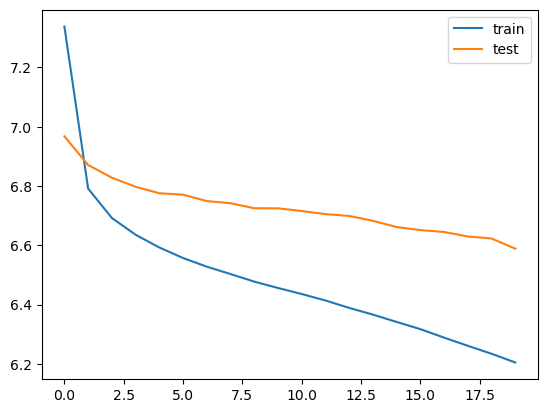

In [41]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [42]:
from keras.models import model_from_json
from keras import backend as K
K.clear_session()
with open('saved_models/LSTM_simple.json', 'r') as f:
    loaded_json = f.read()
    f.close()
    loaded_model = model_from_json(loaded_json)
loaded_model.load_weights('saved_models/LSTM_simple.h5')

from keras import optimizers

optimizer_obj = optimizers.RMSprop(learning_rate = 0.0005, clipvalue = 0.5)
def loss_function(target, prediction):
    # Create mask so that the zero padding values are not included in the computation of loss
    padding_mask = math.logical_not(equal(target, 0))
    padding_mask = cast(padding_mask, float32)
    # Compute a sparse categorical cross-entropy loss on the unmasked values
    loss = sparse_categorical_crossentropy(target, prediction, from_logits=True) * padding_mask
    # Compute the mean loss over the unmasked values
    return reduce_sum(loss) / reduce_sum(padding_mask)
loaded_model.compile(optimizer=optimizer_obj, loss=loss_function)

In [91]:
# temp = loaded_model.predict(y_val_final.reshape(y_val_final.shape[0],y_val_final.shape[1], 1)[:, 0:])
# temp[1]

In [32]:
temp[1].shape
### Outputs probability of each word??

(250, 5487)

In [33]:
y_val_final[1].shape

(250,)

Using early stopping to just get checkpoints, really.

In [213]:
#loading weights after 1 checkpoint
#model.load_weights('./MyModel_tf')

In [137]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [33]:
#history = model.fit([x_train_final,y_train_final[:, :-1]], y_train_final.reshape(y_train_final.shape[0],y_train_final.shape[1], 1)[:, 1:],epochs=100,callbacks=[es],batch_size=128, validation_data=([x_val_final,y_val_final[:, :-1]], y_val_final.reshape(y_val_final.shape[0],y_val_final.shape[1], 1)[:, 1:]))

In [143]:
history.history

{'loss': [3.769752025604248,
  3.769752264022827,
  3.76975154876709,
  3.7697510719299316,
  3.76975154876709,
  3.769752025604248],
 'val_loss': [3.755042552947998,
  3.755042552947998,
  3.75504207611084,
  3.75504207611084,
  3.755042552947998,
  3.75504207611084]}

In [90]:
#saving the entire model once training is completed.
# with open('/trainHistorydict', 'wb') as file:
#     pickle.dump(history.history, file)
# model.save('saved_models/rkv_LSTM_model_att_augm')

In [89]:
# from matplotlib import pyplot
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()
# pyplot.savefig('rkv_LSTM_loss and val_loss.png')

In [227]:
#it's loaded properly, but you can check if you want to
#reloaded_model.summary()

In [ ]:
from tensorflow.keras.models import load_model

In [99]:
reloaded_model = load_model('saved_models/rkv_LSTM_model_att_augm')

In [ ]:
#Mohan's code follows. Remove comments as needed.

In [43]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [146]:
# encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs_1, state_h1, state_c1])

# # Decoder setup
# # Below tensors will hold the states of the previous time step
# decoder_state_input_h = Input(shape=(hidden_dim,))
# decoder_state_input_c = Input(shape=(hidden_dim,))
# decoder_hidden_state_input = Input(shape=(max_text_length,hidden_dim))

# # Get the embeddings of the decoder sequence
# dec_emb2= dec_emb_layer(decoder_inputs) 
# # To predict the next word in the sequence, set the initial states to the states from the previous time step
# decoder_outputs2, state_h2, state_c2 = decoder_LSTM(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# #attention inference
# attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
# decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# # A dense softmax layer to generate prob dist. over the target vocabulary
# decoder_outputs3 = decoder_dense(decoder_inf_concat) 

# # Final decoder model
# decoder_model = Model(
#     [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
#     [decoder_outputs3] + [state_h2, state_c2])

In [44]:
temp = loaded_model.predict(x_val_final[:5])
for i in range(5):
    print(np.argmax(temp[0, -1, :]))

1/1 [==============================] - 0s 94ms/step
2
2
2
2
2


In [183]:
print(np.shape(temp[0]))
print(np.shape(temp[1]))
print(temp[0, 1, 3])
# first index - sequence/summary number
# second index - word out of 250
# third index - probability of each word out of 5481.

(250, 5481)
(250, 5481)
0.02759415


In [184]:
print(np.argmax(temp[0][1]))

5


In [88]:
#y_val_final[1]

In [87]:
print(np.argmax(temp[0, 1]))
# Argmax of one word in the first sequence
print(temp[0, 1])
#
print("Reversed target index word : ", reverse_target_word_index[5])

5
[5.1591013e-07 7.6120917e-04 3.3136684e-04 ... 7.4370764e-06 1.4273202e-05
 1.2147870e-05]
Reversed target index word :  patient


In [53]:
print(np.argmax(temp[0, :, 2], axis = 0))
print(temp[0, :, 2])
print("Reversed target index word : ", reverse_target_word_index[107])
# The mask has made these probabilities look a lot better.

107
[2.98464670e-07 3.31366842e-04 1.66523503e-03 7.98436534e-03
 4.49731126e-02 9.51541364e-02 1.17263541e-01 1.26759037e-01
 1.55247211e-01 1.26164690e-01 1.15695365e-01 1.23888612e-01
 1.28486365e-01 1.06944211e-01 1.02462672e-01 8.99385586e-02
 8.42321739e-02 9.64875519e-02 1.15081549e-01 1.31526232e-01
 1.40463278e-01 1.44412413e-01 1.47541091e-01 1.51220426e-01
 1.60752594e-01 1.68320894e-01 1.68622941e-01 1.66215360e-01
 1.63904607e-01 1.62687853e-01 1.62316442e-01 1.62698194e-01
 1.63991347e-01 1.65887326e-01 1.67398229e-01 1.67775139e-01
 1.68391004e-01 1.68800101e-01 1.69179916e-01 1.69559151e-01
 1.69893920e-01 1.70022354e-01 1.69988692e-01 1.70179754e-01
 1.70397267e-01 1.70228153e-01 1.70822322e-01 1.70868203e-01
 1.70906648e-01 1.70748472e-01 1.70802742e-01 1.70901299e-01
 1.70943350e-01 1.70824692e-01 1.70582086e-01 1.70386925e-01
 1.70470223e-01 1.70912400e-01 1.71067193e-01 1.71146914e-01
 1.71048313e-01 1.70969948e-01 1.71123177e-01 1.71174690e-01
 1.71268776e-01 1.71

In [168]:
len(np.argmax(temp[0, :], axis = 0))

5481

In [185]:
def decode_sequence(input_seq):
    # Encoder outputs
    e_out = loaded_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['bos']

    stop_condition = False
    decoded_sentence = ''
    count = 0
    while not stop_condition:
        
        # Decoder outputs, hidden state and context layer
        output_tokens = loaded_model.predict(input_seq)
        
        sampled_token_index = np.argmax(output_tokens[0][count], axis = 0)
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token
            count += 1
            
        if (sampled_token == 'eos' or count >= 30 or len(decoded_sentence.split()) >= (30)):
            count += 1
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

    return decoded_sentence

In [57]:
def decode_sequence_2(input_seq):
    # Encoder outputs
    e_out = loaded_model.predict(input_seq)
    print("e_out shape: ", np.shape(e_out))
    num_sequences = len(e_out)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['bos']

    stop_condition = False
    decoded_sentences = []
    sequence_count = 0
    word_count = 0
    while sequence_count < num_sequences:
        # Re-initializing all these variables we use
        decoded_sentence = ''
        word_count = 0
        EOS_count = 0
        stop_condition = False
        while word_count < 30 and stop_condition == False:
            output_tokens = e_out[sequence_count][word_count]
            sampled_token_index = np.argmax(output_tokens)
            sampled_token = reverse_target_word_index[sampled_token_index]
            if (sampled_token!='eos'):
                decoded_sentence += ' '+sampled_token
                word_count += 1
            if (sampled_token == 'eos' and word_count <= 30):
                #decoded_sentence += ' '+sampled_token
                word_count += 1
                EOS_count += 1
                #stop_condition = True
                
        print("EOS detected: ", EOS_count)
        decoded_sentences.append(decoded_sentence)
        sequence_count += 1
    return decoded_sentences

In [58]:
decode_sequence_2(x_val_final[:5])

1/1 [==============================] - 0s 72ms/step
e_out shape:  (5, 250, 5481)
EOS detected:  26
EOS detected:  26
EOS detected:  26
EOS detected:  26
EOS detected:  26


[' bos patient year old',
 ' bos patient year old',
 ' bos patient year old',
 ' bos patient year old',
 ' bos patient year old']

In [47]:
def seq2summary(input_seq):
    newString=''
    all_words = set(reverse_target_word_index.keys())
    for i in input_seq:
        if((i!=0 and i!=target_word_index['bos']) and i!=target_word_index['eos'] and i in all_words):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2transcript(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [69]:
orig_dataset = pd.read_csv('mtsamples.csv')
orig_dataset.drop("Unnamed: 0", axis = 1, inplace=True)
orig_dataset.drop("keywords", axis = 1, inplace=True)
orig_dataset.drop_duplicates()
orig_dataset.dropna(axis = 0, inplace = True)

In [195]:
x_train_final[5].reshape(1, max_text_length)

array([[   17,     4,   197,   582,     5,   113,   538,   277,  2481,
         2691,  3607,  4949,     4,   113,     3,   500,  1205,     8,
         1044,   460,    11,   358, 10618,  1687,    14,     8,     2,
         1032,    13,     8,   868,  2303,  1472,  5804,    39,     8,
            3,  1032,     3,   500,  1044,   460,  2480,     5,     5,
            4,   538,  1648,   856,   102,   538,   277,     4,   113,
         2303,  1648,   113,   952,     2,    94,  1571,   236,  1311,
          663,  1773,  1588,     5,     8,     3,  1032,     4,   358,
        10618,  1687,    11,   113,  2303,  1648,   113,   952,     2,
           94,  1571,    16,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [199]:
x_train_final[:5]

array([[ 17,  74, 127, ..., 790, 700,  25],
       [ 17,   4, 197, ...,   0,   0,   0],
       [ 17,  74,  36, ...,   0,   0,   0],
       [ 17, 422,   5, ...,   0,   0,   0],
       [ 17,  74,  36, ...,   0,   0,   0]], dtype=int32)

In [48]:
from datasets import load_metric
import csv

metric = load_metric("rouge")
data1 = pd.read_csv("mtsamples.csv") 

transcriptions_100 = []
actual_summaries_100 = []
predicted_summaries_100 = []

transcriptions_100.append('transcription')
actual_summaries_100.append('actual_summaries')
predicted_summaries_100.append('predicted_summaries')

for i in range(10):
    transcription_data = data1['transcription'][i]
    transcriptions_100.append(data1['transcription'][i])
    actual_summaries_100.append(data1['description'][i])
    
pred_summary = decode_sequence_2(x_train_final[:10])
for item in pred_summary:
    predicted_summaries_100.append(item)

rows = zip(transcriptions_100, actual_summaries_100, predicted_summaries_100)

with open('mtsamples_output_100.csv', "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)

metric.compute(predictions=predicted_summaries_100, references=actual_summaries_100)

1/1 [==============================] - 0s 77ms/step
e_out shape:  (10, 250, 5481)


{'rouge1': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.10606060606060605, recall=0.061983471074380174, fmeasure=0.06684491978609626), high=Score(precision=0.22424242424242424, recall=0.15794306703397612, fmeasure=0.1728854180253032)),
 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.04090909090909091, recall=0.01168831168831169, fmeasure=0.016783216783216783), high=Score(precision=0.09999999999999999, recall=0.03509740259740257, fmeasure=0.048484848484848485)),
 'rougeL': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.11212121212121212, recall=0.061983471074380174, fmeasure=0.06684491978609626), high=Score(precision=0.21825757575757573, recall=0.15794306703397612, fmeasure=0.17184035476718404)),
 'rougeLsum': AggregateScore(low=Score(precision=0.0303030303030303, recall=0.00505050505050505, fmeasure=0.008869179600886916), mid=Score(precision=0.107575

In [187]:
print("original : ", actual_summaries_100[3])
print("predicted : ", predicted_summaries_100[3])

original :   Consult for laparoscopic gastric bypass.
predicted :   bos patient year old


In [193]:
print("original : ", actual_summaries_100[5])
print("predicted : ", predicted_summaries_100[7])

original :   2-D Echocardiogram
predicted :   bos patient year old


In [49]:
predicted_summaries_100

['predicted_summaries',
 ' bos patient year old right eos',
 ' bos patient year old eos',
 ' bos patient year old right eos',
 ' bos patient year old eos',
 ' bos patient year old right right eos',
 ' bos patient year old eos',
 ' bos patient year old eos',
 ' bos patient year old eos',
 ' bos patient year old right eos',
 ' bos patient year old eos']

### These aren't uncommon sentences - nearly every transcription talks about the patient and their age. However, this can still be significantly improved.